# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">Porto Seguro’s Safe Driver Prediction - Kaggle</p>

## Predict if a driver will file an insurance claim next year

<img src='./img/safe-driving-730x432.jpeg' style='height:400px; border-radius: 5px;'/>

---
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">Contents:</p>

* [1. Introduction](#1)
    * [1.1 Data Description](#1.1)
    * [1.2 Libraries](#1.2)
    * [1.3 Loading Dataset](#1.3)
* [2. Preprocessing & Feature Engineering](#2)
    * [2.1 SMOTE](#2.1)
    * [2.2 Cross-validation](#2.2)
    * [2.3 Feature Selection](#2.3)
* [3. Models](#3)
    * [3.1 Lightgbm](#3.1)
    * [3.2 Neural Networks](#3.2)
* [4. Evaluation](#4)
* [5. Kaggle Submission](#5)

<a id="1"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">1- Introduction</p>

<img title="Porto Seguro" src="img/porto-seguro-logo-1-3.png" alt="Porto Seguro" style='height:80px; padding: 10px; padding-right: 15px;' align="center"> 

[Porto Seguro](https://www.portoseguro.com.br/en/institutional) is one of the largest insurance companies in Brazil specialized in car and home insurance. Located in São Paulo, Porto Seguro has been one of the leading insurers in Brazil since its foundation in 1945.

A key challenge faced by all major insurers is, when it comes to car insurance, how to address fairness towards good drivers and try not to penalize those who have a good driving history on account of a few bad drivers. Inaccuracies in car insurance claim predictions usually raise its cost for good drivers and reduce the price for bad ones.

Porto Seguro has been applying Machine Learning for more than 20 years and intends to make car insurance more accessible to everyone. Thinking about that, the company created an online competition to help them explore new and more powerful ML methods.

<img title="Porto Seguro" src="img/Kaggle_logo.png" alt="Porto Seguro" style='height:80px; padding: 10px; padding-right: 15px' align="center">

[Kaggle](https://www.kaggle.com/) is an online community of data scientists and allows users to find and publish data sets, explore and build ML models, and enter competitions to solve data science challenges.

In this [competition](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/), the challenge is build a model that predicts the probability that a car insurance policy holder will file a claim next year.

<a id="1.1"></a>
## Data Description

In the train and test data:

- Features that belong to similar groupings are tagged as such in the feature names (e.g., `ind`, `reg`, `car`, `calc`). 
- Feature names include the postfix `bin` to indicate binary features and `cat` to indicate categorical features.
- Features __without__ these designations are either __continuous or ordinal__.
- Values of `-1` indicate that the feature was missing from the observation. 
- The `target` columns signifies whether or not a claim was filed for that policy holder. 

- `ind` - individuals
- `reg` - regions
- `car` - cars
- `calc` - calculated features

- `_bin` - binary 
- `_cat` - categorical

<a id="1.2"></a>
## Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import random
import json
from pathlib import Path

%matplotlib inline
matplotlib.style.use("ggplot")

# Preprocessing
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import joblib
from numpy import savetxt
from numpy import loadtxt

# Evaluation
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# Hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV

import time
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [3]:
from platform import python_version
print('Python version:', python_version())

Python version: 3.8.5


In [4]:
# !pip install -q -U watermark
%reload_ext watermark
%watermark -a "Leandro Pessini" --iversions

Author: Leandro Pessini

seaborn   : 0.11.1
joblib    : 1.0.1
sklearn   : 0.23.2
numpy     : 1.19.2
json      : 2.0.9
xgboost   : 1.4.1
matplotlib: 3.3.2
lightgbm  : 3.1.1
pandas    : 1.1.3



<a id="1.3"></a>
## Loading Dataset

In [5]:
# Kaggle
#path = "../input/porto-seguro-safe-driver-prediction/"

# Local
path = "./data/"

In [6]:
%%time
train_df = pd.read_csv(path + "train.csv").set_index('id')
test_df = pd.read_csv(path + "test.csv").set_index('id')

CPU times: user 9.78 s, sys: 2.27 s, total: 12.1 s
Wall time: 14.3 s


---
As per competition description, there are a few calculated features. In one of the discussions on Kaggle, it was highlighted that some kind of transformation was applied in order to generate these features. I will drop these features and apply the transformations using my best judgment.

In [7]:
train_df = train_df.drop(train_df.filter(regex='_calc').columns, axis=1)
test_df = test_df.drop(test_df.filter(regex='_calc').columns, axis=1)

In [8]:
print('Train Dataset - Number of rows are',train_df.shape[0], 'and number of columns are ',train_df.shape[1])
print('Test Dataset - Number of rows are',test_df.shape[0], 'and number of columns are ',test_df.shape[1])

Train Dataset - Number of rows are 595212 and number of columns are  38
Test Dataset - Number of rows are 892816 and number of columns are  37


<a id="2"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">2- Preprocessing & Feature Engineering</p>

## Target variable distribution

`target` variable 1 means that a claim was filed and 0 that it was not claimed.

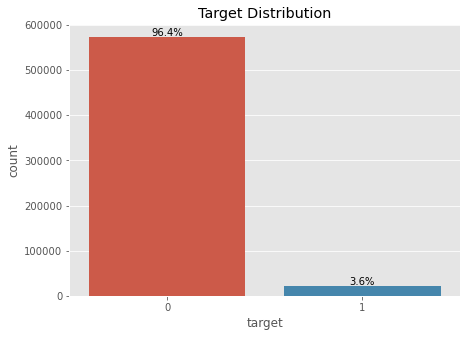

In [9]:
y = train_df.target
fig = plt.figure(figsize=(7, 5))
ax = sns.countplot(y,label="Count")

total_size = len(train_df)

# Display the target value ratio at the top of the bar
for patch in ax.patches:
    height = patch.get_height()
    width = patch.get_width()
    left_coord = patch.get_x()
    percent = height/total_size*100

    ax.text(x=left_coord + width/2.0, 
            y=height + 3000,
            s='{:1.1f}%'.format(percent),
            ha='center')

ax.set_title('Target Distribution');
plt.savefig('./plots/target_distribution.png', dpi=fig.dpi)

---
The target feature has a severe __imbalance distribution__ showing that only __3.6% filled a claim__ and 96.4% did not.

This will be handle by the algorithm through a hyperparameter `is_unbalance = True`.

## Missing values

Values of __`-1`__ indicate that the feature was missing from the observation.

In [10]:
vars_with_missing = []

for f in train_df.columns:
    missings = train_df[train_df[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train_df.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('\nIn total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values

In total, there are 13 variables with missing values


---
Only `ps_car_03_cat` and `ps_car_05_cat` have a large number (~ >= 50%) of missing values.
- ps_car_03_cat has 411231 records (69.09%)
- ps_car_05_cat has 266551 records (44.78%)

There are several ways to __deal with missing data__ such as __Mean Imputation__, __Interpolation__ and __Extrapolation__. I will address this issue later on.

<a id="2.1"></a>
## Metadata

To make data management easier, a meta-info about the variables is added to the DataFrame. It will help handling those variables later on the analysis, data viz and modeling.

- __level__: categorical, numerical, binary
- __dtype__: int, float, str

We do not have information on which features are ordinal or not so a meta-info `numerical` will be added in order to apply __Normalization__ later.

In [11]:
data = []
for f in train_df.columns:
    
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f:
        level = 'categorical'
    elif train_df[f].dtype == float:
        level = 'numerical'
    elif train_df[f].dtype == int:
        level = 'numerical'
    
    # Defining the data type 
    dtype = train_df[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'level': level,
        'dtype': dtype
    }
    
    data.append(f_dict)

In [12]:
meta = pd.DataFrame(data, columns=['varname', 'level', 'dtype'])
meta.set_index('varname', inplace=True)

In [13]:
# Example to extract all categorical variables that are not dropped
meta[(meta.level == 'categorical')].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

### Number of variables per role and level 

In [14]:
pd.DataFrame({'count' : meta.groupby(['level'])['level'].size()}).reset_index()

,level,count
0,binary,12
1,categorical,14
2,numerical,12


## Exploratory Analysis

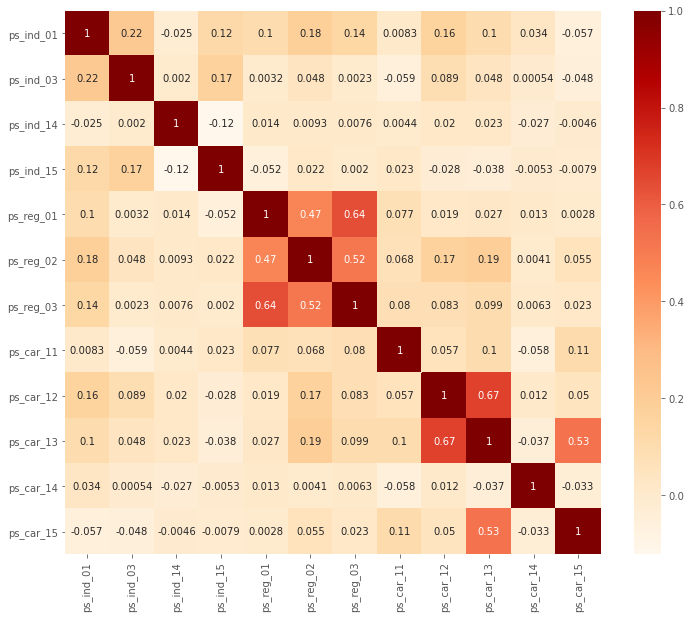

In [15]:
numerical_features = meta[(meta.level == 'numerical')].index
fig = plt.figure(figsize=(12, 10))
cont_corr = train_df[numerical_features].corr() # Correlation between continuous features
sns.heatmap(cont_corr, annot=True, cmap='OrRd'); # Plot heatmap
plt.savefig('./plots/heatmap.png', dpi=fig.dpi)

There are a strong correlations between the variables:

- ps_car_12 and ps_car_13 (0.67)
- ps_reg_01 and ps_reg_03 (0.64)
- ps_car_13 and ps_car_15 (0.53)
- ps_reg_02 and ps_reg_03 (0.52)

Heatmap showed low number of correlated variables, we'll look at each of the highly correlated variables separately.

In [16]:
# Convert -1 from training data copy to np.NaN
train_copy = train_df.copy().replace(-1, np.NaN)
train_copy = train_copy.dropna()
s = train_copy.sample(frac=0.1)

__NOTE__: sampling was applied to speed up the process.

### ps_car_12 x ps_car_13

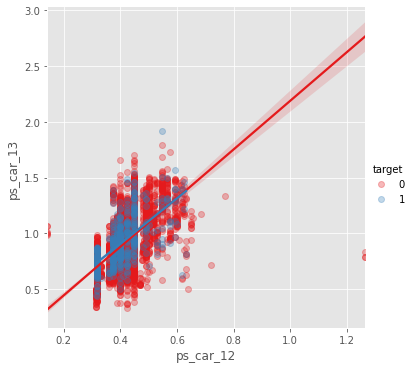

In [17]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.savefig('./plots/ps_car_12xps_car_13.png', dpi=fig.dpi)
plt.show()

### ps_reg_01 x ps_reg_03

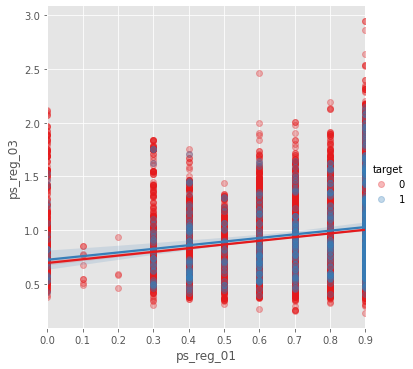

In [18]:
sns.lmplot(x='ps_reg_01', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.savefig('./plots/ps_reg_01xps_reg_03.png', dpi=fig.dpi)
plt.show()

### ps_reg_02 x ps_reg_03

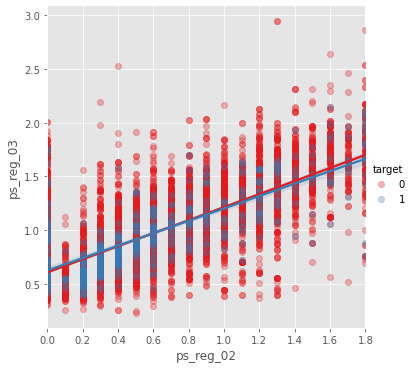

In [19]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.savefig('./plots/ps_reg_02xps_reg_03.png', dpi=fig.dpi)
plt.show()

As the number of correlated variables is rather low, dimensionality reduction will not be applied and the model will do the heavy-lifting.

## Binary features

__Distribution__ of binary data and the __corresponding__ values of __target__ variable.

<Figure size 432x288 with 0 Axes>

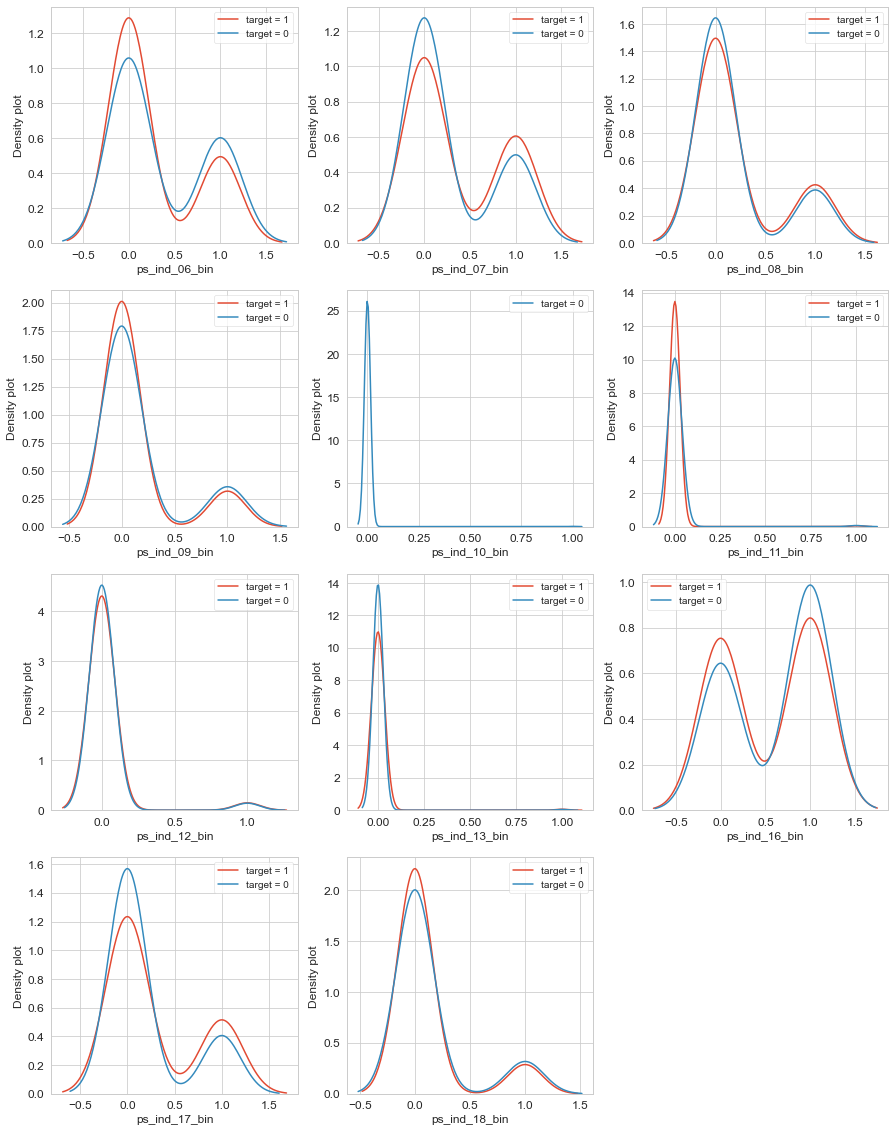

In [20]:
warnings.simplefilter(action='ignore')
var = [col for col in train_copy.columns if '_bin' in col]
i = 0

s_bin = train_copy.sample(frac=0.1)
t1 = s_bin.loc[s_bin['target'] != 0]
t0 = s_bin.loc[s_bin['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(figsize=(15,20))

for feature in var:
    i += 1
    plt.subplot(4,3,i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.legend(loc='best')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('./plots/binary-features.png', dpi=fig.dpi)
plt.show()

<a id="2.2"></a>
## Feature Importance

As the categorical variables are already numerical, there is no need to apply LabelEncoding.

__Reference__:
>Raschka, S., & Mirjalili, V. (2019). Python Machine Learning. Zaltbommel, Netherlands: Van Haren Publishing.

## Opening prefit model

In [21]:
try:
    with open("./files/LightGBM_feature_importances.pkl") as f:
        features_classifier = joblib.load(f.name)
        X = train_df.drop(['target'], inplace=False, axis=1)
except IOError:
    print("File not accessible")

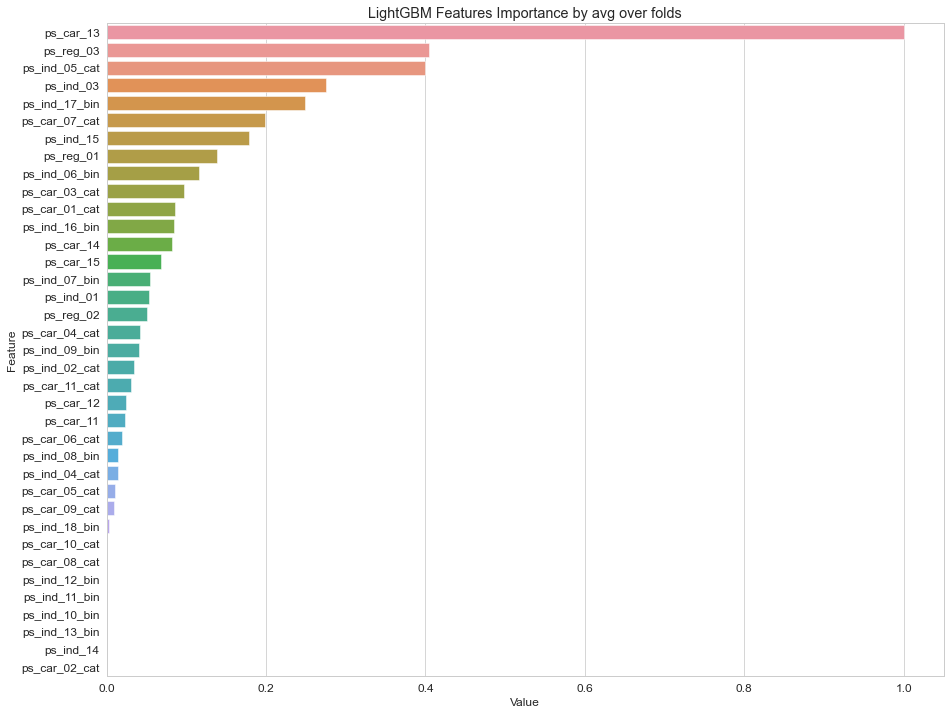

In [22]:
#Plotting features importance

feature_imp = pd.DataFrame(sorted(zip(features_classifier.feature_importances_,X.columns)), columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1))

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance by avg over folds')
plt.savefig('./plots/lgbm_importances.png', dpi=fig.dpi)
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

## Combining train and test data

Now that we have the Feature Importance, let's concat the train and test data in order to perform transformation on both.

In [23]:
all_data = pd.concat([train_df, test_df], ignore_index=True)
all_data = all_data.drop('target', axis=1) # Remove target value

## Dropping less important features

In [24]:
drop_features = ['ps_car_02_cat', 'ps_ind_14','ps_ind_10_bin', 
                 'ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin', 
                 'ps_car_08_cat','ps_car_10_cat', 'ps_ind_18_bin', 'ps_car_09_cat', 'ps_car_05_cat']


all_data_remaining = all_data.drop(drop_features, axis=1)

print('Number of features before selection: {}'.format(all_data.shape[1]))
print('Number of features after selection: {}'.format(all_data_remaining.shape[1]))


Number of features before selection: 37
Number of features after selection: 26


In [25]:
all_data_feat_sel = all_data_remaining.copy()

## Handling missing data

The study of missing data was formalized by Donald Rubin with the concept of missing mechanism in which missing-data indicators are random variables and assigned a distribution. Missing data mechanism describes the underlying mechanism that generates missing data.

It is important to consider missing data mechanism when deciding how to deal with missing data. Because this is unknown, I will consider the missing data as part of the dataset (new category for example) and just create a new feature adding the total number of missing data.

>Rubin, D. B. (1975). INFERENCE AND MISSING DATA. ETS Research Bulletin Series, 1975(1), i–19. https://doi.org/10.1002/j.2333-8504.1975.tb01053.x

In [26]:
feature_names = all_data_feat_sel.columns.tolist()
num_features = [c for c in feature_names if '_cat' not in c]
all_data_feat_sel['missing'] = (all_data_feat_sel==-1).sum(axis=1).astype(float)
num_features.append('missing')

<a id="2.2"></a>
## Feature scaling using StandardScaler

In [27]:
features_n = [col for col in all_data_feat_sel.columns if ('_cat' not in col and '_bin' not in col)]
all_data_n = all_data_feat_sel.copy()

features = all_data_n[features_n]

# using default 
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

all_data_n[features_n] = features

<a id="2.3"></a>
## One-hot encoding categorical features

In [28]:
all_data_enc = all_data_n.copy()
categoricals_features = [col for col in all_data_feat_sel.columns if '_cat' in col]

print('Before dummification we have {} variables in train'.format(all_data_enc.shape[1]))
all_data_enc = pd.get_dummies(all_data_enc, columns=categoricals_features, drop_first=True)
print('After dummification we have {} variables in train'.format(all_data_enc.shape[1]))

Before dummification we have 27 variables in train
After dummification we have 176 variables in train


## Split train and test data 

In [29]:
num_train = train_df.shape[0] # Number of train data 
final_data = all_data_enc.copy()

# Divide train data and test data
X = np.asarray(final_data[:num_train])
X_test = np.asarray(final_data[num_train:])

y = np.asarray(train_df['target'])

# Splitting the train to use 20% later on evaluation
X, X_eval, y, y_eval = train_test_split(X, y, test_size = 0.2)

<a id="3"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">3- Model</p>

## Gini coefficient - Kaggle Evaluation

![Gini](./img/lorenz-curve.png)

The Gini index or Gini coefficient is a statistical measure of distribution which was developed by the Italian statistician Corrado Gini in 1912. It is used as a gauge of economic inequality, measuring income distribution among a population.

The Gini coefficient is equal to the area below the line of perfect equality (0.5 by definition) minus the area below the Lorenz curve, divided by the area below the line of perfect equality. In other words, it is double the area between the Lorenz curve and the line of perfect equality.

__Reference__:
>https://theblog.github.io/post/gini-coefficient-intuitive-explanation/

In [30]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

# LightGBM

In [54]:
lgb_params = {
        'objective': 'binary',
        'is_unbalance': True, # As we have a severe imbalanced class
        'metric': 'auc',
        'n_estimators': 500,
        'n_jobs': 2,
        'learning_rate': 0.01,
        'num_leaves': 30
    }
lgb_c = lgb.LGBMClassifier()
lgb_c.set_params(**lgb_params)

LGBMClassifier(is_unbalance=True, learning_rate=0.01, metric='auc',
               n_estimators=500, n_jobs=2, num_leaves=30, objective='binary')

__NOTE__
- __'is_unbalance': True__

Sets the weights of the dominated label to 1, and the weights of the dominant labels to the ratio of count of dominant/dominated.

## K-fold cross validation

When your data set is not be large enough to slice into three representative parts, cross validation can help with that. K-fold cross validation prevents overfitting to your test data without further reducing the size of your training data set.

K-fold cross validation reports on the performance of a model on several (k) samples from your training set. This provides a less biased evaluation of the model. However, K-fold cross validation is more computationally expensive than slicing your data into three parts. It re-fits the model and tests it k-times, for each iteration, as opposed to one time.

In [56]:
%%time

preds_proba_lgb = np.zeros([X.shape[0],2])
preds_lgb = np.zeros(X.shape[0])

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

for n_fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print('#'*40, f'Fold {n_fold+1} out of {folds.n_splits}', '#'*40)
    
    X_train, y_train = X[train_index], y[train_index] # Train data
    X_val, y_val = X[test_index], y[test_index] # Valid data
    
    lgb_c.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
              verbose=250, early_stopping_rounds=50)
    
    preds_proba_lgb[test_index] += lgb_c.predict_proba(X_val, raw_score=False)
    preds_lgb[test_index] += lgb_c.predict(X_val, raw_score=False)

    # Normalized Gini coefficient for prediction probabilities
    gini_score = gini_normalized(y_val, preds_proba_lgb[test_index][:, 1])
    print(f'Fold {n_fold+1} gini score: {gini_score}\n')

######################################## Fold 1 out of 5 ########################################
Training until validation scores don't improve for 50 rounds
[250]	training's auc: 0.671216	valid_1's auc: 0.6393
[500]	training's auc: 0.688003	valid_1's auc: 0.641501
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.688003	valid_1's auc: 0.641501
Fold 1 gini score: 0.2830025558645673

######################################## Fold 2 out of 5 ########################################
Training until validation scores don't improve for 50 rounds
[250]	training's auc: 0.672502	valid_1's auc: 0.63852
Early stopping, best iteration is:
[308]	training's auc: 0.676627	valid_1's auc: 0.639076
Fold 2 gini score: 0.2781511995670359

######################################## Fold 3 out of 5 ########################################
Training until validation scores don't improve for 50 rounds
[250]	training's auc: 0.673034	valid_1's auc: 0.633694
Early stopping, best iteration is:


LightGBM total: __6min 43s__

## Saving the results

In [ ]:
# Save LightGBM model to file in the current working directory

joblib_file = "./files/lightgbm/LightGBM_Model.pkl"  
joblib.dump(lgb_c, joblib_file)

In [ ]:
with open('./files/lightgbm/evals_result.json', 'w') as fp:
    json.dump(lgb_c.evals_result_, fp, sort_keys=True, indent=4)

In [ ]:
np.savetxt('./files/lightgbm/preds_lgb.csv', preds_lgb, fmt = '%i')

In [ ]:
np.savetxt('./files/lightgbm/preds_prob_lgb.csv', preds_proba_lgb, fmt = '%s', delimiter=",")

# XGBoost (eXtreme Gradient Boosting)

In [32]:
params_xgb = {
    'objective': 'binary:logistic',
    'learning_rate': 0.01,
    'n_estimators': 500,
    #'missing': -1,
    'n_jobs': 2,
    'random_state': 1986
}
xgb_model = xgb.XGBClassifier(**params_xgb)

In [33]:
%%time

preds_proba_xgb = np.zeros([X.shape[0],2])
preds_xgb = np.zeros(X.shape[0])

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

for n_fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print('#'*40, f'Fold {n_fold+1} out of {folds.n_splits}', '#'*40)
    
    X_train, y_train = X[train_index], y[train_index] # Train data
    X_val, y_val = X[test_index], y[test_index] # Valid data
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
            eval_metric='auc', early_stopping_rounds=50, verbose = False)
    
    preds_proba_xgb[test_index] += xgb_model.predict_proba(X_val)
    preds_xgb[test_index] += xgb_model.predict(X_val)

    # Normalized Gini coefficient for prediction probabilities
    gini_score = gini_normalized(y_val, preds_proba_xgb[test_index][:, 1])
    print(f'Fold {n_fold+1} gini score: {gini_score}\n')


######################################## Fold 1 out of 5 ########################################
[0]	validation_0-auc:0.61272	validation_1-auc:0.60901
[1]	validation_0-auc:0.61273	validation_1-auc:0.60904
[2]	validation_0-auc:0.61506	validation_1-auc:0.61046
[3]	validation_0-auc:0.61544	validation_1-auc:0.61072
[4]	validation_0-auc:0.61554	validation_1-auc:0.61053
[5]	validation_0-auc:0.61703	validation_1-auc:0.61205
[6]	validation_0-auc:0.61709	validation_1-auc:0.61194
[7]	validation_0-auc:0.61970	validation_1-auc:0.61331
[8]	validation_0-auc:0.62041	validation_1-auc:0.61381
[9]	validation_0-auc:0.62081	validation_1-auc:0.61355
[10]	validation_0-auc:0.62113	validation_1-auc:0.61376
[11]	validation_0-auc:0.62185	validation_1-auc:0.61449
[12]	validation_0-auc:0.62240	validation_1-auc:0.61481
[13]	validation_0-auc:0.62273	validation_1-auc:0.61494
[14]	validation_0-auc:0.62320	validation_1-auc:0.61500
[15]	validation_0-auc:0.62364	validation_1-auc:0.61561
[16]	validation_0-auc:0.62367	va

[147]	validation_0-auc:0.64004	validation_1-auc:0.62313
[148]	validation_0-auc:0.64006	validation_1-auc:0.62310
[149]	validation_0-auc:0.64016	validation_1-auc:0.62309
[150]	validation_0-auc:0.64023	validation_1-auc:0.62308
[151]	validation_0-auc:0.64028	validation_1-auc:0.62313
[152]	validation_0-auc:0.64033	validation_1-auc:0.62311
[153]	validation_0-auc:0.64042	validation_1-auc:0.62322
[154]	validation_0-auc:0.64048	validation_1-auc:0.62322
[155]	validation_0-auc:0.64057	validation_1-auc:0.62327
[156]	validation_0-auc:0.64066	validation_1-auc:0.62324
[157]	validation_0-auc:0.64072	validation_1-auc:0.62326
[158]	validation_0-auc:0.64078	validation_1-auc:0.62329
[159]	validation_0-auc:0.64083	validation_1-auc:0.62331
[160]	validation_0-auc:0.64092	validation_1-auc:0.62329
[161]	validation_0-auc:0.64101	validation_1-auc:0.62330
[162]	validation_0-auc:0.64107	validation_1-auc:0.62330
[163]	validation_0-auc:0.64111	validation_1-auc:0.62326
[164]	validation_0-auc:0.64119	validation_1-auc:

[294]	validation_0-auc:0.65253	validation_1-auc:0.62787
[295]	validation_0-auc:0.65265	validation_1-auc:0.62790
[296]	validation_0-auc:0.65287	validation_1-auc:0.62802
[297]	validation_0-auc:0.65293	validation_1-auc:0.62806
[298]	validation_0-auc:0.65316	validation_1-auc:0.62819
[299]	validation_0-auc:0.65338	validation_1-auc:0.62830
[300]	validation_0-auc:0.65348	validation_1-auc:0.62832
[301]	validation_0-auc:0.65369	validation_1-auc:0.62842
[302]	validation_0-auc:0.65385	validation_1-auc:0.62849
[303]	validation_0-auc:0.65389	validation_1-auc:0.62851
[304]	validation_0-auc:0.65402	validation_1-auc:0.62858
[305]	validation_0-auc:0.65418	validation_1-auc:0.62865
[306]	validation_0-auc:0.65435	validation_1-auc:0.62877
[307]	validation_0-auc:0.65442	validation_1-auc:0.62881
[308]	validation_0-auc:0.65457	validation_1-auc:0.62888
[309]	validation_0-auc:0.65473	validation_1-auc:0.62896
[310]	validation_0-auc:0.65482	validation_1-auc:0.62895
[311]	validation_0-auc:0.65497	validation_1-auc:

[441]	validation_0-auc:0.66954	validation_1-auc:0.63462
[442]	validation_0-auc:0.66964	validation_1-auc:0.63470
[443]	validation_0-auc:0.66972	validation_1-auc:0.63469
[444]	validation_0-auc:0.66983	validation_1-auc:0.63469
[445]	validation_0-auc:0.66990	validation_1-auc:0.63471
[446]	validation_0-auc:0.67004	validation_1-auc:0.63476
[447]	validation_0-auc:0.67011	validation_1-auc:0.63482
[448]	validation_0-auc:0.67021	validation_1-auc:0.63481
[449]	validation_0-auc:0.67028	validation_1-auc:0.63484
[450]	validation_0-auc:0.67030	validation_1-auc:0.63486
[451]	validation_0-auc:0.67040	validation_1-auc:0.63489
[452]	validation_0-auc:0.67044	validation_1-auc:0.63489
[453]	validation_0-auc:0.67053	validation_1-auc:0.63491
[454]	validation_0-auc:0.67059	validation_1-auc:0.63497
[455]	validation_0-auc:0.67071	validation_1-auc:0.63499
[456]	validation_0-auc:0.67082	validation_1-auc:0.63500
[457]	validation_0-auc:0.67090	validation_1-auc:0.63503
[458]	validation_0-auc:0.67098	validation_1-auc:

[87]	validation_0-auc:0.63288	validation_1-auc:0.62316
[88]	validation_0-auc:0.63299	validation_1-auc:0.62315
[89]	validation_0-auc:0.63300	validation_1-auc:0.62308
[90]	validation_0-auc:0.63301	validation_1-auc:0.62311
[91]	validation_0-auc:0.63301	validation_1-auc:0.62306
[92]	validation_0-auc:0.63312	validation_1-auc:0.62309
[93]	validation_0-auc:0.63315	validation_1-auc:0.62315
[94]	validation_0-auc:0.63315	validation_1-auc:0.62312
[95]	validation_0-auc:0.63322	validation_1-auc:0.62314
[96]	validation_0-auc:0.63330	validation_1-auc:0.62314
[97]	validation_0-auc:0.63342	validation_1-auc:0.62307
[98]	validation_0-auc:0.63350	validation_1-auc:0.62304
[99]	validation_0-auc:0.63362	validation_1-auc:0.62304
[100]	validation_0-auc:0.63363	validation_1-auc:0.62303
[101]	validation_0-auc:0.63364	validation_1-auc:0.62311
[102]	validation_0-auc:0.63375	validation_1-auc:0.62316
[103]	validation_0-auc:0.63377	validation_1-auc:0.62315
[104]	validation_0-auc:0.63376	validation_1-auc:0.62312
[105]

[234]	validation_0-auc:0.64519	validation_1-auc:0.62789
[235]	validation_0-auc:0.64525	validation_1-auc:0.62792
[236]	validation_0-auc:0.64543	validation_1-auc:0.62792
[237]	validation_0-auc:0.64552	validation_1-auc:0.62799
[238]	validation_0-auc:0.64561	validation_1-auc:0.62797
[239]	validation_0-auc:0.64568	validation_1-auc:0.62804
[240]	validation_0-auc:0.64581	validation_1-auc:0.62809
[241]	validation_0-auc:0.64593	validation_1-auc:0.62812
[242]	validation_0-auc:0.64608	validation_1-auc:0.62814
[243]	validation_0-auc:0.64615	validation_1-auc:0.62817
[244]	validation_0-auc:0.64630	validation_1-auc:0.62816
[245]	validation_0-auc:0.64644	validation_1-auc:0.62816
[246]	validation_0-auc:0.64651	validation_1-auc:0.62820
[247]	validation_0-auc:0.64658	validation_1-auc:0.62825
[248]	validation_0-auc:0.64668	validation_1-auc:0.62829
[249]	validation_0-auc:0.64682	validation_1-auc:0.62834
[250]	validation_0-auc:0.64695	validation_1-auc:0.62834
[251]	validation_0-auc:0.64705	validation_1-auc:

[381]	validation_0-auc:0.66408	validation_1-auc:0.63451
[382]	validation_0-auc:0.66421	validation_1-auc:0.63453
[383]	validation_0-auc:0.66434	validation_1-auc:0.63457
[384]	validation_0-auc:0.66444	validation_1-auc:0.63460
[385]	validation_0-auc:0.66451	validation_1-auc:0.63461
[386]	validation_0-auc:0.66461	validation_1-auc:0.63463
[387]	validation_0-auc:0.66474	validation_1-auc:0.63467
[388]	validation_0-auc:0.66483	validation_1-auc:0.63469
[389]	validation_0-auc:0.66492	validation_1-auc:0.63470
[390]	validation_0-auc:0.66506	validation_1-auc:0.63476
[391]	validation_0-auc:0.66516	validation_1-auc:0.63477
[392]	validation_0-auc:0.66529	validation_1-auc:0.63475
[393]	validation_0-auc:0.66540	validation_1-auc:0.63480
[394]	validation_0-auc:0.66543	validation_1-auc:0.63481
[395]	validation_0-auc:0.66548	validation_1-auc:0.63486
[396]	validation_0-auc:0.66558	validation_1-auc:0.63489
[397]	validation_0-auc:0.66567	validation_1-auc:0.63492
[398]	validation_0-auc:0.66574	validation_1-auc:

[26]	validation_0-auc:0.62873	validation_1-auc:0.61140
[27]	validation_0-auc:0.62900	validation_1-auc:0.61174
[28]	validation_0-auc:0.62923	validation_1-auc:0.61181
[29]	validation_0-auc:0.62959	validation_1-auc:0.61213
[30]	validation_0-auc:0.62951	validation_1-auc:0.61202
[31]	validation_0-auc:0.62955	validation_1-auc:0.61228
[32]	validation_0-auc:0.62976	validation_1-auc:0.61240
[33]	validation_0-auc:0.62983	validation_1-auc:0.61245
[34]	validation_0-auc:0.63017	validation_1-auc:0.61267
[35]	validation_0-auc:0.63009	validation_1-auc:0.61268
[36]	validation_0-auc:0.63034	validation_1-auc:0.61287
[37]	validation_0-auc:0.63038	validation_1-auc:0.61287
[38]	validation_0-auc:0.63065	validation_1-auc:0.61294
[39]	validation_0-auc:0.63076	validation_1-auc:0.61305
[40]	validation_0-auc:0.63074	validation_1-auc:0.61305
[41]	validation_0-auc:0.63116	validation_1-auc:0.61319
[42]	validation_0-auc:0.63117	validation_1-auc:0.61329
[43]	validation_0-auc:0.63138	validation_1-auc:0.61339
[44]	valid

[174]	validation_0-auc:0.64095	validation_1-auc:0.61834
[175]	validation_0-auc:0.64097	validation_1-auc:0.61830
[176]	validation_0-auc:0.64097	validation_1-auc:0.61831
[177]	validation_0-auc:0.64106	validation_1-auc:0.61835
[178]	validation_0-auc:0.64112	validation_1-auc:0.61840
[179]	validation_0-auc:0.64125	validation_1-auc:0.61848
[180]	validation_0-auc:0.64133	validation_1-auc:0.61853
[181]	validation_0-auc:0.64136	validation_1-auc:0.61850
[182]	validation_0-auc:0.64144	validation_1-auc:0.61856
[183]	validation_0-auc:0.64155	validation_1-auc:0.61856
[184]	validation_0-auc:0.64158	validation_1-auc:0.61857
[185]	validation_0-auc:0.64165	validation_1-auc:0.61859
[186]	validation_0-auc:0.64170	validation_1-auc:0.61858
[187]	validation_0-auc:0.64176	validation_1-auc:0.61865
[188]	validation_0-auc:0.64180	validation_1-auc:0.61862
[189]	validation_0-auc:0.64188	validation_1-auc:0.61860
[190]	validation_0-auc:0.64196	validation_1-auc:0.61864
[191]	validation_0-auc:0.64203	validation_1-auc:

[321]	validation_0-auc:0.65665	validation_1-auc:0.62577
[322]	validation_0-auc:0.65678	validation_1-auc:0.62584
[323]	validation_0-auc:0.65684	validation_1-auc:0.62583
[324]	validation_0-auc:0.65697	validation_1-auc:0.62592
[325]	validation_0-auc:0.65714	validation_1-auc:0.62602
[326]	validation_0-auc:0.65730	validation_1-auc:0.62610
[327]	validation_0-auc:0.65745	validation_1-auc:0.62622
[328]	validation_0-auc:0.65750	validation_1-auc:0.62622
[329]	validation_0-auc:0.65768	validation_1-auc:0.62628
[330]	validation_0-auc:0.65783	validation_1-auc:0.62637
[331]	validation_0-auc:0.65799	validation_1-auc:0.62643
[332]	validation_0-auc:0.65813	validation_1-auc:0.62653
[333]	validation_0-auc:0.65824	validation_1-auc:0.62663
[334]	validation_0-auc:0.65835	validation_1-auc:0.62668
[335]	validation_0-auc:0.65849	validation_1-auc:0.62667
[336]	validation_0-auc:0.65865	validation_1-auc:0.62677
[337]	validation_0-auc:0.65878	validation_1-auc:0.62684
[338]	validation_0-auc:0.65891	validation_1-auc:

[468]	validation_0-auc:0.67320	validation_1-auc:0.63120
[469]	validation_0-auc:0.67331	validation_1-auc:0.63120
[470]	validation_0-auc:0.67341	validation_1-auc:0.63123
[471]	validation_0-auc:0.67350	validation_1-auc:0.63127
[472]	validation_0-auc:0.67362	validation_1-auc:0.63126
[473]	validation_0-auc:0.67368	validation_1-auc:0.63132
[474]	validation_0-auc:0.67377	validation_1-auc:0.63136
[475]	validation_0-auc:0.67386	validation_1-auc:0.63138
[476]	validation_0-auc:0.67396	validation_1-auc:0.63140
[477]	validation_0-auc:0.67410	validation_1-auc:0.63141
[478]	validation_0-auc:0.67416	validation_1-auc:0.63146
[479]	validation_0-auc:0.67431	validation_1-auc:0.63148
[480]	validation_0-auc:0.67435	validation_1-auc:0.63147
[481]	validation_0-auc:0.67445	validation_1-auc:0.63149
[482]	validation_0-auc:0.67456	validation_1-auc:0.63156
[483]	validation_0-auc:0.67463	validation_1-auc:0.63159
[484]	validation_0-auc:0.67469	validation_1-auc:0.63161
[485]	validation_0-auc:0.67480	validation_1-auc:

[114]	validation_0-auc:0.63488	validation_1-auc:0.62168
[115]	validation_0-auc:0.63492	validation_1-auc:0.62172
[116]	validation_0-auc:0.63498	validation_1-auc:0.62168
[117]	validation_0-auc:0.63515	validation_1-auc:0.62179
[118]	validation_0-auc:0.63522	validation_1-auc:0.62180
[119]	validation_0-auc:0.63524	validation_1-auc:0.62190
[120]	validation_0-auc:0.63543	validation_1-auc:0.62196
[121]	validation_0-auc:0.63559	validation_1-auc:0.62205
[122]	validation_0-auc:0.63560	validation_1-auc:0.62201
[123]	validation_0-auc:0.63564	validation_1-auc:0.62203
[124]	validation_0-auc:0.63580	validation_1-auc:0.62212
[125]	validation_0-auc:0.63583	validation_1-auc:0.62219
[126]	validation_0-auc:0.63597	validation_1-auc:0.62229
[127]	validation_0-auc:0.63602	validation_1-auc:0.62239
[128]	validation_0-auc:0.63602	validation_1-auc:0.62239
[129]	validation_0-auc:0.63617	validation_1-auc:0.62242
[130]	validation_0-auc:0.63624	validation_1-auc:0.62244
[131]	validation_0-auc:0.63626	validation_1-auc:

[261]	validation_0-auc:0.64737	validation_1-auc:0.62875
[262]	validation_0-auc:0.64746	validation_1-auc:0.62882
[263]	validation_0-auc:0.64753	validation_1-auc:0.62885
[264]	validation_0-auc:0.64766	validation_1-auc:0.62891
[265]	validation_0-auc:0.64776	validation_1-auc:0.62897
[266]	validation_0-auc:0.64785	validation_1-auc:0.62902
[267]	validation_0-auc:0.64799	validation_1-auc:0.62910
[268]	validation_0-auc:0.64808	validation_1-auc:0.62919
[269]	validation_0-auc:0.64821	validation_1-auc:0.62924
[270]	validation_0-auc:0.64836	validation_1-auc:0.62932
[271]	validation_0-auc:0.64843	validation_1-auc:0.62932
[272]	validation_0-auc:0.64860	validation_1-auc:0.62941
[273]	validation_0-auc:0.64868	validation_1-auc:0.62949
[274]	validation_0-auc:0.64883	validation_1-auc:0.62955
[275]	validation_0-auc:0.64892	validation_1-auc:0.62957
[276]	validation_0-auc:0.64905	validation_1-auc:0.62964
[277]	validation_0-auc:0.64913	validation_1-auc:0.62967
[278]	validation_0-auc:0.64930	validation_1-auc:

[408]	validation_0-auc:0.66561	validation_1-auc:0.63643
[409]	validation_0-auc:0.66575	validation_1-auc:0.63647
[410]	validation_0-auc:0.66587	validation_1-auc:0.63649
[411]	validation_0-auc:0.66596	validation_1-auc:0.63650
[412]	validation_0-auc:0.66604	validation_1-auc:0.63656
[413]	validation_0-auc:0.66609	validation_1-auc:0.63655
[414]	validation_0-auc:0.66617	validation_1-auc:0.63665
[415]	validation_0-auc:0.66623	validation_1-auc:0.63661
[416]	validation_0-auc:0.66642	validation_1-auc:0.63667
[417]	validation_0-auc:0.66650	validation_1-auc:0.63667
[418]	validation_0-auc:0.66662	validation_1-auc:0.63667
[419]	validation_0-auc:0.66668	validation_1-auc:0.63671
[420]	validation_0-auc:0.66677	validation_1-auc:0.63671
[421]	validation_0-auc:0.66686	validation_1-auc:0.63677
[422]	validation_0-auc:0.66692	validation_1-auc:0.63686
[423]	validation_0-auc:0.66700	validation_1-auc:0.63686
[424]	validation_0-auc:0.66706	validation_1-auc:0.63684
[425]	validation_0-auc:0.66715	validation_1-auc:

[53]	validation_0-auc:0.63219	validation_1-auc:0.61948
[54]	validation_0-auc:0.63219	validation_1-auc:0.61946
[55]	validation_0-auc:0.63231	validation_1-auc:0.61950
[56]	validation_0-auc:0.63239	validation_1-auc:0.61963
[57]	validation_0-auc:0.63236	validation_1-auc:0.61954
[58]	validation_0-auc:0.63249	validation_1-auc:0.61960
[59]	validation_0-auc:0.63259	validation_1-auc:0.61977
[60]	validation_0-auc:0.63261	validation_1-auc:0.61975
[61]	validation_0-auc:0.63274	validation_1-auc:0.61977
[62]	validation_0-auc:0.63278	validation_1-auc:0.61997
[63]	validation_0-auc:0.63284	validation_1-auc:0.61994
[64]	validation_0-auc:0.63288	validation_1-auc:0.62002
[65]	validation_0-auc:0.63302	validation_1-auc:0.62016
[66]	validation_0-auc:0.63305	validation_1-auc:0.62015
[67]	validation_0-auc:0.63310	validation_1-auc:0.62014
[68]	validation_0-auc:0.63311	validation_1-auc:0.62011
[69]	validation_0-auc:0.63315	validation_1-auc:0.62008
[70]	validation_0-auc:0.63329	validation_1-auc:0.62030
[71]	valid

[201]	validation_0-auc:0.64247	validation_1-auc:0.62447
[202]	validation_0-auc:0.64250	validation_1-auc:0.62445
[203]	validation_0-auc:0.64264	validation_1-auc:0.62454
[204]	validation_0-auc:0.64269	validation_1-auc:0.62451
[205]	validation_0-auc:0.64279	validation_1-auc:0.62463
[206]	validation_0-auc:0.64298	validation_1-auc:0.62469
[207]	validation_0-auc:0.64307	validation_1-auc:0.62470
[208]	validation_0-auc:0.64316	validation_1-auc:0.62479
[209]	validation_0-auc:0.64326	validation_1-auc:0.62478
[210]	validation_0-auc:0.64328	validation_1-auc:0.62476
[211]	validation_0-auc:0.64336	validation_1-auc:0.62479
[212]	validation_0-auc:0.64349	validation_1-auc:0.62481
[213]	validation_0-auc:0.64358	validation_1-auc:0.62487
[214]	validation_0-auc:0.64370	validation_1-auc:0.62496
[215]	validation_0-auc:0.64377	validation_1-auc:0.62492
[216]	validation_0-auc:0.64388	validation_1-auc:0.62489
[217]	validation_0-auc:0.64395	validation_1-auc:0.62486
[218]	validation_0-auc:0.64407	validation_1-auc:

[348]	validation_0-auc:0.66174	validation_1-auc:0.63074
[349]	validation_0-auc:0.66187	validation_1-auc:0.63075
[350]	validation_0-auc:0.66195	validation_1-auc:0.63078
[351]	validation_0-auc:0.66204	validation_1-auc:0.63080
[352]	validation_0-auc:0.66211	validation_1-auc:0.63079
[353]	validation_0-auc:0.66223	validation_1-auc:0.63080
[354]	validation_0-auc:0.66236	validation_1-auc:0.63082
[355]	validation_0-auc:0.66254	validation_1-auc:0.63088
[356]	validation_0-auc:0.66262	validation_1-auc:0.63093
[357]	validation_0-auc:0.66281	validation_1-auc:0.63099
[358]	validation_0-auc:0.66286	validation_1-auc:0.63104
[359]	validation_0-auc:0.66298	validation_1-auc:0.63108
[360]	validation_0-auc:0.66309	validation_1-auc:0.63104
[361]	validation_0-auc:0.66318	validation_1-auc:0.63111
[362]	validation_0-auc:0.66336	validation_1-auc:0.63118
[363]	validation_0-auc:0.66343	validation_1-auc:0.63119
[364]	validation_0-auc:0.66352	validation_1-auc:0.63119
[365]	validation_0-auc:0.66361	validation_1-auc:

[495]	validation_0-auc:0.67630	validation_1-auc:0.63391
[496]	validation_0-auc:0.67636	validation_1-auc:0.63390
[497]	validation_0-auc:0.67649	validation_1-auc:0.63392
[498]	validation_0-auc:0.67652	validation_1-auc:0.63395
[499]	validation_0-auc:0.67656	validation_1-auc:0.63399
Fold 5 gini score: 0.2679882559195657

CPU times: user 3h 32min 52s, sys: 1min 49s, total: 3h 34min 42s
Wall time: 1h 58min 25s


XGBoost total: __3h 34min 42s__

In [34]:
# Save XGBoost model to file in the current working directory

joblib_file = "./files/xgb/XGBoost_Model.pkl"  
joblib.dump(xgb_model, joblib_file)

['./files/xgb/XGBoost_Model.pkl']

In [36]:
with open('./files/xgb/evals_result.json', 'w') as fp:
    json.dump(xgb_model.evals_result_, fp, sort_keys=True, indent=4)

In [37]:
np.savetxt('./files/xgb/preds_xgb.csv', preds_xgb, fmt = '%i')

In [38]:
np.savetxt('./files/xgb/preds_prob_xgb.csv', preds_proba_xgb, fmt = '%s', delimiter=",")

## Random Search for Hyper-Parameter Optimization

Random Search for Hyper-Parameter Optimization

>https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

---

__NOTE__: Due to computing resources limitations I did not perform RandomizedSearchCV locally

__Parameters Tuning__ was performed on Kaggle and yield the output below:

---

![RandomizedSearchCV](./img/randomSearchCV.png)

`random_search.best_params_`

![Best-Params](./img/best-params.png)

# LightGBM Tunned

In [58]:
lgb_params_tuned = {
                'objective': 'binary',
                'is_unbalance': True, # As we have a severe imbalanced class
                'metric': 'auc',
                'n_estimators': 2500,
                'n_jobs': 2,
                'num_leaves': 50,
                'max_bin': 2000,
                'learning_rate': 0.001,
                'min_data_in_leaf': 200,
                'feature_fraction': 0.7,
                'bagging_freq': 1,
                'bagging_fraction': 0.5
            }

lgb_tuned = lgb.LGBMClassifier()
lgb_tuned.set_params(**lgb_params_tuned)

LGBMClassifier(bagging_fraction=0.5, bagging_freq=1, feature_fraction=0.7,
               is_unbalance=True, learning_rate=0.001, max_bin=2000,
               metric='auc', min_data_in_leaf=200, n_estimators=2500, n_jobs=2,
               num_leaves=50, objective='binary')

In [60]:
%%time

preds_proba_lgb_tuned = np.zeros([X.shape[0],2])
preds_lgb_tuned = np.zeros(X.shape[0])

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

for n_fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print('#'*40, f'Fold {n_fold+1} out of {folds.n_splits}', '#'*40)
    
    X_train, y_train = X[train_index], y[train_index] # Train data
    X_val, y_val = X[test_index], y[test_index] # Valid data
    
    lgb_tuned.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
                  verbose=1250, early_stopping_rounds=200)
    
    preds_proba_lgb_tuned[test_index] += lgb_tuned.predict_proba(X_val)
    preds_lgb_tuned[test_index] += lgb_tuned.predict(X_val)

    # Normalized Gini coefficient for prediction probabilities
    gini_score = gini_normalized(y_val, preds_proba_lgb_tuned[test_index][:, 1])
    print(f'Fold {n_fold+1} gini score: {gini_score}\n')

######################################## Fold 1 out of 5 ########################################
Training until validation scores don't improve for 200 rounds
[1250]	training's auc: 0.679549	valid_1's auc: 0.640271
[2500]	training's auc: 0.690902	valid_1's auc: 0.642823
Did not meet early stopping. Best iteration is:
[2500]	training's auc: 0.690902	valid_1's auc: 0.642823
Fold 1 gini score: 0.2856459142142984

######################################## Fold 2 out of 5 ########################################
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
Training until

LightGBM Tuned total: __1h 6min 3s__

## Saving the results

In [61]:
# Save LightGBM model to file in the current working directory

joblib_file = "./files/lightgbm/LightGBM_tuned.pkl"  
joblib.dump(lgb_tuned, joblib_file)

['./files/lightgbm/LightGBM_tuned.pkl']

In [62]:
with open('./files/lightgbm/evals_result_tuned.json', 'w') as fp:
    json.dump(lgb_tuned.evals_result_, fp, sort_keys=True, indent=4)

In [63]:
np.savetxt('./files/lightgbm/preds_lgb_tuned.csv', preds_lgb_tuned, fmt = '%i')

In [64]:
np.savetxt('./files/lightgbm/preds_prob_lgb_tuned.csv', preds_proba_lgb_tuned, fmt = '%s', delimiter=",")

<a id="4"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">4- Evaluation</p>

In [ ]:
#validation_tuned = np.fromstring(loadtxt('./files/model-gini-tuned/validation_preds_lgb_tuned.csv', dtype=float))

Probabilistic metrics are designed specifically to quantify the uncertainty in a classifier’s predictions. Algorithms such as Logistic Regression, Random Forest and Gradient Boosting give probability outputs. Probability outputs can be converted to class output by creating a threshold probability.


- Are you predicting probabilities?
    - Do you need class labels?
        - Is the positive class more important?
            Use Precision-Recall AUC
        - Are both classes important?
            Use ROC AUC
        - Do you need probabilities?
            Use Brier Score and Brier Skill Score
- Are you predicting class labels?
    - Is the positive class more important?
        - Are False Negatives and False Positives Equally Important?
            Use F1-Measure
        - Are False Negatives More Important?
            Use F2-Measure
        - Are False Positives More Important?
            Use F0.5-Measure
    - Are both classes important?
        - Do you have < 80%-90% Examples for the Majority Class? 
            Use Accuracy
        - Do you have > 80%-90% Examples for the Majority Class? 
            Use G-Mean

>https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

>https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

In [77]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

## LightGBM - First Model

In [71]:
lightgbm_model = joblib.load('./files/lightgbm/LightGBM_Model.pkl')
preds_lgb = np.fromstring(loadtxt('./files/lightgbm/preds_lgb.csv'))
preds_prob_lgb = np.loadtxt('./files/lightgbm/preds_prob_lgb.csv', delimiter=',')

In [73]:
lightgbm_model.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('auc', 0.6746999889685782)]),
             'valid_0': OrderedDict([('auc', 0.6411622185675661)])})

## XGBoost

In [74]:
xgb_model = joblib.load('./files/xgb/XGBoost_Model.pkl')
preds_xgb = np.fromstring(loadtxt('./files/xgb/preds_xgb.csv'))
preds_prob_xgb = np.loadtxt('./files/xgb/preds_prob_xgb.csv', delimiter=',')

## LightGBM - Tuned Model

In [76]:
lightgbm_tuned = joblib.load('./files/lightgbm/LightGBM_tuned.pkl')
preds_lgb_tuned = np.fromstring(loadtxt('./files/lightgbm/preds_lgb_tuned.csv'))
preds_prob_lgb_tuned = np.loadtxt('./files/lightgbm/preds_prob_lgb_tuned.csv', delimiter=',')

## First model

Unlike the ROC Curve, a precision-recall curve focuses on the performance of a classifier on the positive (minority class) only.

In [ ]:
precision, recall, thresholds = precision_recall_curve(y, val_preds_lgb)
# plot the roc curve for the model
no_skill = len(y[y==1]) / len(y)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision,  label='LightGBM')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
auc_prc = auc(recall, precision)
print(auc_prc)

In [ ]:
from sklearn.metrics import average_precision_score
average_precision_score(y, val_preds_lgb)

In [ ]:

from sklearn.metrics import precision_score, recall_score

In [ ]:
val_preds_lgb_target = np.where(val_preds_lgb > 0.5, 1, 0)

In [ ]:
pr = precision_score(
    y,
    val_preds_lgb_target,
    labels=None,
    pos_label=1,
    average='binary',
    sample_weight=None,
    zero_division='warn',
)
re = recall_score(
    y,
    val_preds_lgb_target,
    labels=None,
    pos_label=1,
    average='binary',
    sample_weight=None,
    zero_division='warn',
)

In [ ]:
pr, re

In [ ]:
threshold = 0
yscore = (y >= threshold)
precision_score(y, yscore), recall_score(y, yscore)

In [ ]:

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# Precision-Recall AUC

In [ ]:
print('LightGBM Gini Score:', Gini(y, val_preds_lgb_local))

In [ ]:
ax = lgb.plot_metric(evals_result_local)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y, val_preds_lgb_tuned)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(lgb, X, y)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

<a id="5"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">5- Kaggle Submission</p>

In [84]:
# X_test is the test.csv provided with all transformations applied
test_preds_lgb = lightgbm_tuned.predict_proba(X_test, raw_score=True)
test_preds_xgb = xgb_model.predict_proba(X_test)

In [85]:
test_preds_lgb

array([[0.59988417, 0.40011583],
       [0.63802445, 0.36197555],
       [0.59173928, 0.40826072],
       ...,
       [0.58583429, 0.41416571],
       [0.64952514, 0.35047486],
       [0.60898566, 0.39101434]])

In [94]:
test_preds_xgb

array([[0.9686973 , 0.03130271],
       [0.9716009 , 0.02839909],
       [0.9642592 , 0.03574078],
       ...,
       [0.9656865 , 0.0343135 ],
       [0.9696627 , 0.03033729],
       [0.96927303, 0.03072699]], dtype=float32)

In [ ]:
submission = pd.read_csv(path + 'sample_submission.csv', index_col='id')
submission['target'] = test_preds_lgb
submission.to_csv('./kaggle-submission/LightGBM.csv')

In [ ]:
submission = pd.read_csv(path + 'sample_submission.csv', index_col='id')
submission['target'] = test_preds_xgb
submission.to_csv('./kaggle-submission/XGBoost.csv')

In [ ]:
submission = pd.read_csv(path + 'sample_submission.csv', index_col='id')
ensemble_test_preds = test_preds_lgb * 0.6 + test_preds_xgb * 0.4
submission['target'] = oof_test_preds
submission.to_csv('./kaggle-submission/Ensemble.csv')

__Note:__ At first, I thought the name of file should have been `submission.csv` as well. For that reason all 3 files submitted to Kaggle have the same name.

## Score screenshot

<img src='./ignore-folder/score/scores.png' style='height:800px; border-radius: 5px;'/>

<img src='./ignore-folder/score/private_leaderboard.png' style='height:600px; border-radius: 5px;'/>

---
## Kaggle Leaderboard
After submitting I got a score of 0.28332 (Public) and 0.29022 (Private). For the __Private Leaderboard__ it would rank at a position between 259 and 265.